In [1]:
import numpy as np
import tensorflow as tf
import helpful_functions as hf
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [2]:
#---------- Subtraction 5x5x16 ----------#
encoder_inputs = keras.Input(shape=(32, 32, 1), name="img_input")
x = layers.Conv2D(8, 3, activation="relu")(encoder_inputs)
x = layers.Conv2D(16, 3, activation="relu")(x)
block_1_output = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(16, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(16, 3, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
block_3_output = layers.add([x, block_2_output])

x  = layers.Conv2D(16, 3, activation="relu")(block_3_output)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_outputs = layers.MaxPooling2D(2)(x)

encoder = keras.Model(encoder_inputs, encoder_outputs, name="encoder")
encoder.summary()

#decoder
decoder_inputs = keras.Input(shape=(5, 5, 16), name="decoder_input")
x = layers.UpSampling2D(2)(decoder_inputs)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
block_4_output = layers.Conv2DTranspose(16, 3, activation="relu")(x)

x = layers.Conv2DTranspose(16, 3, activation="relu", padding="same")(block_4_output)
x = layers.Conv2DTranspose(16, 3, activation="relu", padding="same")(x)
block_5_output = layers.add([x, block_4_output])

x = layers.Conv2DTranspose(16, 3, activation="relu", padding="same")(block_5_output)
x = layers.Conv2DTranspose(16, 3, activation="relu", padding="same")(x)
block_6_output = layers.add([x, block_5_output])

x = layers.UpSampling2D(2)(block_6_output)
x = layers.Conv2DTranspose(8, 3, activation="relu")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="relu")(x)

decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")
decoder.summary()

autoencoder_input1 = keras.Input(shape=(32, 32, 1), name="input_img1")
autoencoder_input2 = keras.Input(shape=(32, 32, 1), name="input_img2")
encoded_img1 = encoder(autoencoder_input1)
encoded_img2 = encoder(autoencoder_input2)
encoded_img3 = layers.subtract((encoded_img1, encoded_img2))
#decoded_img1 = decoder(encoded_img1)
#decoded_img2 = decoder(encoded_img2)
decoded_img3 = decoder(encoded_img3)
autoencoder = keras.Model(inputs=[autoencoder_input1,autoencoder_input2],
                          outputs=decoded_img3, name="autoencoder")
autoencoder.summary()

Metal device set to: Apple M2
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_input (InputLayer)         [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 30, 30, 8)    80          ['img_input[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)              (None, 28, 28, 16)   1168        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 14, 14, 16)   0           ['conv2d_1[0][0]']               
                                                              

2023-04-08 22:32:51.948605: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-08 22:32:51.948970: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder_input (InputLayer)     [(None, 5, 5, 16)]   0           []                               
                                                                                                  
 up_sampling2d (UpSampling2D)   (None, 10, 10, 16)   0           ['decoder_input[0][0]']          
                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 12, 12, 16)  2320        ['up_sampling2d[0][0]']          
 ose)                                                                                             
                                                                                                  
 conv2d_transpose_1 (Conv2DTran  (None, 14, 14, 16)  2320        ['conv2d_transpose[0][0]'] 

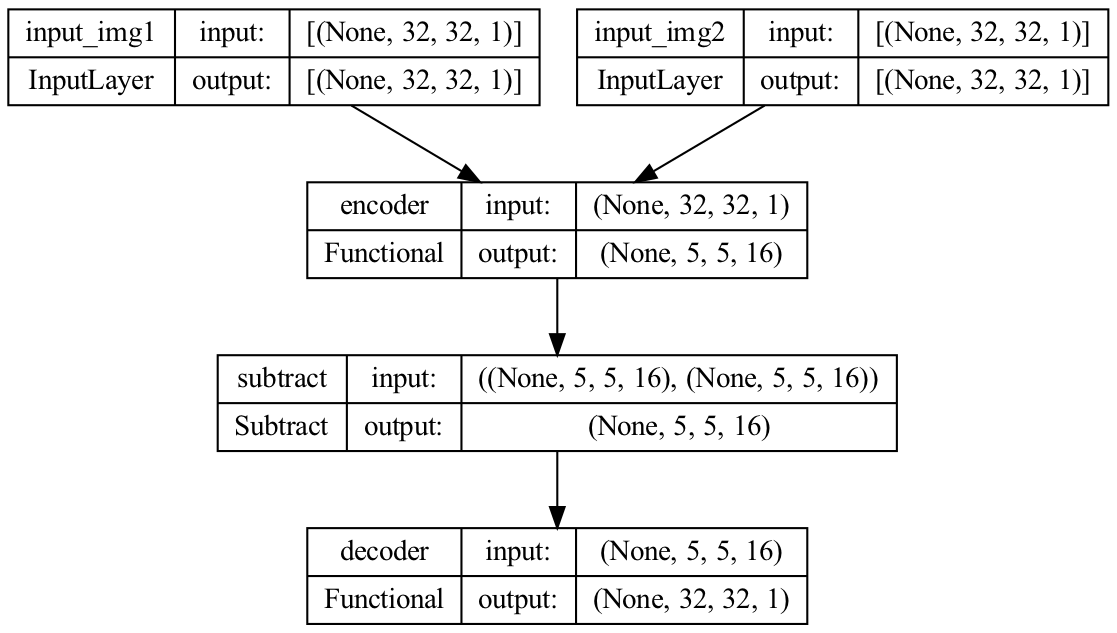

In [3]:
keras.utils.plot_model(autoencoder, "output/struktur_autoencoder/subAutoencoder.png", show_shapes=True, dpi=150)

In [3]:
# load data_set
data_set = hf.load_dataset_npz('data_set/10000samples_3_8_ratio03_sub.npz')
#data_set = hf.load_dataset_npz('data_set/10000samples_3_8_sub_noise.npz')
data_set = data_set.astype('float32')
x_train = data_set[:8000, :1]
y_train = data_set[:8000,2]
x_test = data_set[8000:, :1]
y_test = data_set[8000:, 2]

x_train_ell = data_set[:8000, 1]
y_train_rec = data_set[:8000, 2]
x_train_all = data_set[:8000, 0]

x_test_ell = data_set[8000:, 1]
y_test_rec = data_set[8000:, 2]
x_test_all = data_set[8000:, 0]
print(f"x_train shape: {np.shape(x_train)}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (8000, 1, 32, 32, 1)
y_train shape: (8000, 32, 32, 1)
x_test shape: (2000, 1, 32, 32, 1)
y_test shape: (2000, 32, 32, 1)


In [4]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics=['mean_squared_error'])

monitor = EarlyStopping(monitor='mean_squared_error', min_delta=1e-4, patience=5,
                        verbose=1, mode='auto', restore_best_weights=True)

history = autoencoder.fit([x_train_all, x_train_ell], y_train_rec, epochs=200,
                          validation_data=((x_test_all,x_test_ell), y_test_rec),
                          shuffle=True, batch_size=800, callbacks=[monitor]
                          )

Epoch 1/200


2023-01-24 16:00:10.726495: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-24 16:00:11.099643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 0.0369 - mean_squared_error: 0.0369

2023-01-24 16:00:13.307265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 3s 171ms/step - loss: 0.0369 - mean_squared_error: 0.0369 - val_loss: 0.0200 - val_mean_squared_error: 0.0200
Epoch 2/200
10/10 [==============================] - 1s 130ms/step - loss: 0.0163 - mean_squared_error: 0.0163 - val_loss: 0.0141 - val_mean_squared_error: 0.0141
Epoch 3/200
10/10 [==============================] - 1s 131ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0111 - val_mean_squared_error: 0.0111
Epoch 4/200
10/10 [==============================] - 1s 131ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0093 - val_mean_squared_error: 0.0093
Epoch 5/200
10/10 [==============================] - 1s 135ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 6/200
10/10 [==============================] - 1s 128ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 7/200
10/10 [===============

In [5]:
# make predictions
# = autoencoder.predict([x_test[0:10,1],x_test[0:10,0]])
predictions = autoencoder.predict([x_test_all,x_test_ell])
predictions.shape

 5/63 [=>............................] - ETA: 0s 

2023-01-24 16:00:56.935600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 1s 9ms/step


(2000, 32, 32, 1)

In [18]:
dif_list = []
for i in range(len(predictions)):
    max_value = np.amax(predictions[i])
    min_value = np.amin(predictions[i])
    dif = max_value - min_value
    dif_list.append(dif)
max_dif = np.amax(dif_list)
print(max_dif)

1.2901077


In [20]:
mse = tf.keras.losses.MeanSquaredError()
#mse(y_test[:,3], predictions[3]).numpy()
print(f"mse is: {mse(y_test_rec, predictions).numpy()}")
ssim = tf.image.ssim(y_test_rec, predictions,max_val=max_dif)
ssim_mean = np.mean(ssim)
#print(f"ssim is for sample {12}: {ssim[12].numpy()}")
print(f"mean of ssim is: {ssim_mean}")

mse is: 0.0010122794192284346
mean of ssim is: 0.9883142113685608


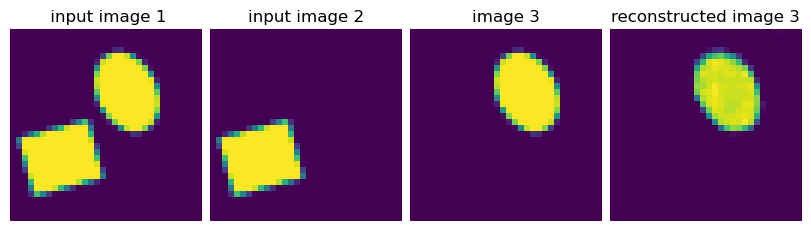

In [7]:
def show_img_sub(sample_num, img_ori, img_predic):
    data_set = img_ori
    x_test_ell = data_set[8000:, 1]
    y_test_rec = data_set[8000:, 2]
    x_test_all = data_set[8000:, 0]
    predictions = img_predic
    img_num = len(data_set[0])
    fig1, ax1 = plt.subplots(1, img_num+1, figsize=(8, 6), constrained_layout=True)
    #fig1.suptitle('Original image', y=0.75)
    ax1[0].imshow(x_test_all[sample_num - 1], origin='lower')
    ax1[0].set_title(f' input image 1')
    ax1[0].axis('off')
    ax1[1].imshow(x_test_ell[sample_num - 1], origin='lower')
    ax1[1].set_title(f'input image 2')
    ax1[1].axis('off')
    ax1[2].imshow(y_test_rec[sample_num - 1], origin='lower')
    ax1[2].set_title(f'image 3')
    ax1[2].axis('off')
    ax1[3].imshow(predictions[sample_num-1], origin='lower')
    ax1[3].set_title(f'reconstructed image 3')
    ax1[3].axis('off')

show_img_sub(40,data_set,predictions)